In [1]:
from pathlib import Path

import geopandas as gpd
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns

In [2]:
province_name_mapping = {
    "Alava": "Araba/Álava",
    "Álava": "Araba/Álava",
    "PAÍS VASCO": "País Vasco/Euskadi",
    "PAIS VASCO": "País Vasco/Euskadi",
    "NAVARRA": "Navarra",
    "LA RIOJA": "La Rioja",
    "ARAGÓN": "Aragón",
    "ARAGON": "Aragón",
    "CATALUÑA": "Cataluña/Catalunya",
    "BALEARES": "Illes Balears",
    "Avila": "Ávila",
    "CASTILLA Y LEÓN": "Castilla y León",
    "CASTILLA Y LEON": "Castilla y León",
    "MADRID": "Madrid",
    "CASTILLA-LA MANCHA": "Castilla-La Mancha",
    "C. VALENCIANA": "Comunitat Valenciana",
    "R. DE MURCIA": "Región de Murcia",
    "EXTREMADURA": "Extremadura",
    "ANDALUCÍA": "Andalucía",
    "ANDALUCIA": "Andalucía",
    "CANARIAS": "Canarias",
    "Guipúzcoa": "Gipuzkoa",
    "GALICIA": "Galicia",
    "P. DE ASTURIAS": "Principado de Asturias",
    "CANTABRIA": "Cantabria",
    "Vizcaya": "Bizkaia",
    "S.C. de Tenerife": "Santa Cruz de Tenerife",
    "Alicante": "Alacant/Alicante",
    "Castellón": "Castelló/Castellón",
    "Valencia": "València/Valencia",
}

In [3]:
def normalize_province_name(input_province_name: str) -> str:
    if input_province_name in province_name_mapping.keys():
        return province_name_mapping.get(input_province_name)
    return input_province_name

In [4]:
def read_excel_file(file_path):
    df = pd.read_excel(file_path, skiprows=6, na_values="–", header=None)

    # change column names
    df.columns = ["province", "total", "table_olive", "olive_oil"]

    # add year column
    df["year"] = int(file_path.stem)

    # normalize values in province column
    df["province"] = df["province"].str.strip().apply(normalize_province_name)

    # fill NA values in numeric columns with zero
    df[["total", "table_olive", "olive_oil"]] = df[
        ["total", "table_olive", "olive_oil"]
    ].fillna(0)

    # drop empty rows
    df = df.dropna()

    # fix dtype
    df = df.astype(
        {
            "province": "string[pyarrow]",
            "total": "int32",
            "table_olive": "int32",
            "olive_oil": "int32",
        }
    )

    return df

In [5]:
data_dir = Path("../data/olive-data-destination/")

In [6]:
df_list = [read_excel_file(file_path) for file_path in data_dir.iterdir()]

In [7]:
data = pd.concat(df_list)

In [8]:
data.head()

,province,total,table_olive,olive_oil,year
1,Araba/Álava,205,0,205,1998
2,País Vasco/Euskadi,205,0,205,1998
4,Navarra,6843,105,6738,1998
6,La Rioja,2868,15,2853,1998
8,Huesca,5727,0,5727,1998


In [9]:
data.isna().sum()

province       0
total          0
table_olive    0
olive_oil      0
year           0
dtype: int64

# Load Spain map

In [10]:
spain_map = gpd.read_file("../data/maps/spain_map.geojson")
spain_map = spain_map[
    spain_map["community"] != "Gibraltar. Territorio no asociado a ninguna autonomía"
]

In [11]:
spain_map.head()

,community,province,geometry
0,País Vasco/Euskadi,Araba/Álava,"POLYGON ((-2.76808 42.61408, -2.76863 42.61334..."
1,Castilla-La Mancha,Albacete,"POLYGON ((-2.55212 38.08501, -2.55207 38.08517..."
2,Comunitat Valenciana,Alacant/Alicante,"MULTIPOLYGON (((-0.75223 37.88691, -0.75225 37..."
3,Andalucía,Almería,"MULTIPOLYGON (((-3.03624 35.93791, -3.03637 35..."
4,Castilla y León,Ávila,"POLYGON ((-5.43382 40.24491, -5.4343 40.24276,..."


# Province matching

In [12]:
def is_province(province_name: str) -> bool:
    return any(spain_map["province"] == province_name) or any(
        spain_map["community"] == province_name
    )

In [13]:
provinces_from_data = data["province"].unique()

In [14]:
for province in provinces_from_data:
    if not is_province(province):
        print(f"{province}")

ESPAÑA


# Province/Community rows:

Some rows in the dataset represents aggregations at the community level. We should remove these rows.

To do so, for each value in the `province` column we need to know whther it's a province or communtiy.

In [15]:
spain_provinces = spain_map["province"].unique()

In [16]:
single_province_communities = (
    spain_map["community"].value_counts().pipe(lambda x: x[x == 1]).index
).values

In [17]:
provinces_to_keep = np.unique(
    np.concatenate((single_province_communities, spain_provinces))
)

In [18]:
data = data[data["province"].isin(provinces_to_keep)]

In [20]:
data.head()

,province,total,table_olive,olive_oil,year
1,Araba/Álava,205,0,205,1998
4,Navarra,6843,105,6738,1998
6,La Rioja,2868,15,2853,1998
8,Huesca,5727,0,5727,1998
9,Teruel,15215,1352,13863,1998


In [25]:
data_long = data.drop(columns=["total"]).melt(
    id_vars=["province", "year"],
    value_vars=["table_olive", "olive_oil"],
)

In [26]:
data_long.head()

,province,year,variable,value
0,Araba/Álava,1998,table_olive,0
1,Navarra,1998,table_olive,105
2,La Rioja,1998,table_olive,15
3,Huesca,1998,table_olive,0
4,Teruel,1998,table_olive,1352


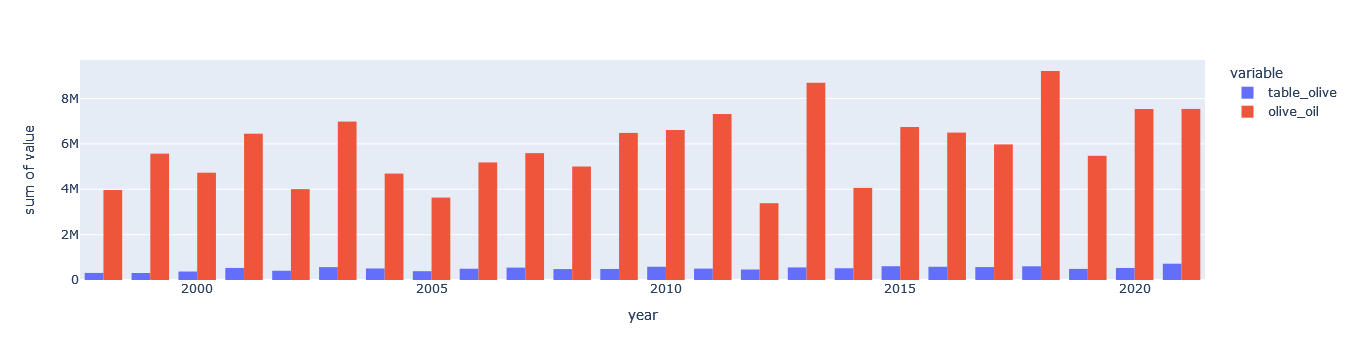

In [28]:
fig = px.histogram(
    data_frame=data_long, x="year", y="value", color="variable", barmode="group"
)

fig.show()